# Temperature Profile Classification - 2 Class system
GMM classification of Southern Ocean Argo float temperature profile data. This notebook looks at automatic generation for PCA N values, with 2 classes.<br><br>
### Dask import

<br>

### Choices for data

In [1]:
#File imports
maskName = "OceanMaskESM2"
dataFileName = "GMMSampleData3AL.npy"
sampleFileName = "GMMSampleTimeGeo3.npy"

#Data definitions
lastESMDecade = slice('2005-01','2014-12')

#Custom GMM variables
pcaThreshold = 0.98
pcaNControl = 0 #set to int value to select, otherwise pcaThreshold is used to automatically assign value
firstComponentMin = 2
firstComponentMax = 2
firstIterationSkip = 1
firstBicLoopControl = 5 #number of times bic value is calculated for each number of classes
secondIternation = False
secondBicLoopControl = 4
bicSpread = 5
cvType = "full"

<br>

### Libaries and Modules
Importing the necessary libaries and modules for the notebook.

In [2]:
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
import dask.dataframe as dd
import fsspec
import matplotlib.dates as mdates
import matplotlib as mpl ###
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm
from sklearn import mixture
from sklearn.decomposition import PCA
from sklearn import preprocessing

print("Imports complete")

Imports complete


<br>

### Importing data sets
Importing the data for the models.

<b>Import sample data set and corresponding time/geo data</b>

In [4]:
sampleDataLabelled = np.load(dataFileName)
sampleDepthAxis = sampleDataLabelled[0]
sampleData = sampleDataLabelled[1:]

sampleTimeGeo = np.load(sampleFileName, allow_pickle=True)
print("Sample data loaded into sampleData.\nSample time geo data loaded into sampleTimeGeo.")

Sample data loaded into sampleData.
Sample time geo data loaded into sampleTimeGeo.


<br>
<b>Loading ocean Mask</b>

In [5]:
maskFile = xr.open_dataset(maskName)
oceanMask = maskFile.to_array()
print("Mask Loaded and stored in oceanMask")

Mask Loaded and stored in oceanMask


<br>
<b>Combining sample data and sample time/geo data</b>

In [6]:
metaData = {"Lat":sampleTimeGeo[0], "Lon":sampleTimeGeo[1], "Time":sampleTimeGeo[2]}
sampleMetaDF = pd.DataFrame(metaData, columns=["Lat", "Lon", "Time"])
sampleDataDF = pd.DataFrame(sampleData, columns=sampleDepthAxis)
sampleDF = pd.concat([sampleMetaDF,sampleDataDF], axis=1)
print("SampleTimeGeo converted to datafile (sampleMetaDF). SampleData converted to datafile (sampleDataDF). Datafiles combined into sampleDF.")

SampleTimeGeo converted to datafile (sampleMetaDF). SampleData converted to datafile (sampleDataDF). Datafiles combined into sampleDF.


<br>

### Plotting functions
<b>Functions:</b>
<ul>
<li>bicPlot - Plots BIC score array against component number.
<li>locationPlotTime - Plots locations of an input data array on a map with a colour scale for time.
<li>tempPointPlot - Plots the temperature profile of a single point against depth.
<li>tempGroupPlot - Plots the mean/+-1std temperature profiles of all classes in input dataArrays (seperate mean and std).
</ul>

In [7]:
def bicPlot(bicArray, startNo, endNo, skipNo, title, label, plotNo):
    '''Plots input BIC score array'''
    plt.figure(plotNo, figsize=(20, 8))
    plt.style.use("seaborn-darkgrid")
    componentRange = range(startNo, endNo, skipNo)
    plt.plot(componentRange, bicArray, label = str(label))
    
    bicArrayMax = np.max(bicArray)
    plt.xticks(componentRange)
    plt.xlim([startNo-0.5, endNo+0.5])
    plt.ylim([np.min(bicArray)*1.01 - 0.02*bicArrayMax, bicArrayMax])
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("Number of components")
    plt.ylabel("BIC score")
    plt.title(title)
    
    
def locationPlotGroup(metaDataArray, size, plotNo):
    '''Plots locations of numpy arrays with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(metaDataArray[1], metaDataArray[0], transform=ccrs.PlateCarree(), c =  metaDataArray[3], cmap='RdBu_r')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Grouped Sample Locations ("+str(len(metaDataArray[0]))+")")  
    
    
def locationPlotTime(dataArray, size, plotNo):
    '''Plots locations of numpy arrays with date colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataArray[1], dataArray[0], transform=ccrs.PlateCarree(), c= mdates.date2num(dataArray[2]), cmap='brg')
    cb = plt.colorbar(im)
    loc = mdates.AutoDateLocator()
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray[0]))+")")
    
    
def tempPointPlot(dataArray, label, title, plotNo):
    '''Displays temperature profile plot for a given data set, singular point'''
    plt.figure(plotNo)
    plt.plot(dataArray, sampleDepthAxis, label = label)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(str(title))
    plt.gca().invert_yaxis()

    
def tempGroupProfile(dataArrayMean, dataArrayStd, plotNo):
    '''Displays mean /+-1 std temperature profiles for classes in dataArrayMean and dataArrayStd. Requires sampleDepthAxis'''
    dataCompNo = len(dataArrayMean)   
    columnNames = sampleDFSortMeans.columns.values
    dataStart = np.where(columnNames == sampleDepthAxis[0])[0][0]
    subPlotX = int(np.ceil(dataCompNo/5))
    
    plt.figure(plotNo, figsize=(35, 10*subPlotX))
    plt.style.use("seaborn-darkgrid")
    palette = cm.coolwarm(np.linspace(0,1, dataCompNo))
    
    for i in range(dataCompNo):
        meanT = dataArrayMean.iloc[i, dataStart:].to_numpy()
        stdT = dataArrayStd.iloc[i, dataStart:].to_numpy()
        
        plt.subplot(subPlotX, 5, i+1)
        plt.plot(meanT, sampleDepthAxis, marker='', linestyle="solid", color=palette[i], linewidth=6.0, alpha=0.9)
        plt.plot(meanT+stdT, sampleDepthAxis, marker='', linestyle="dashed", color=palette[i], linewidth=6.0, alpha=0.9)
        plt.plot(meanT-stdT, sampleDepthAxis, marker='', linestyle="dashed", color=palette[i], linewidth=6.0, alpha=0.9)
        
        plt.xlim([-2,20])
        plt.ylim([0,1000])
        ax = plt.gca()
        ax.invert_yaxis()
        ax.grid(True)
        
        fs = 16 #font size
        plt.xlabel("Temperature (°C)", fontsize=fs)
        plt.ylabel("Depth (m)", fontsize=fs)
        plt.title("Class = "+str(i), fontsize=fs)
        mpl.rc("xtick", labelsize=fs)
        mpl.rc("ytick", labelsize=fs)
        
        '''
        textstr = '\n'.join((
            r'N profs. = %i' % (nprofs[nrow], ),
            r'Mean lon = %i' % (meanLon, ),
            r'Mean lat = %i' % (meanLat, ),
            r'Post. = %i' % (meanMaxPP, )))
        props = dict(boxstyle="round", facecolor="wheat", alpha=0.8)
        ax.text(0.45, 0.25, textstr, transform=ax.transAxes, fontsize=fs, verticalalignment='top', bbox=props)'''

print("Plotting functions defined")

Plotting functions defined


<br>

### Scaling
<b>Scaling Implementation</b><br>
Applying scaling to the data set, ensuring all levels have same influence over data.

In [9]:
sampleDataScaled = preprocessing.scale(sampleData)
print("Scaling of sampleData complete, stored in sampleDataScaled.")

Scaling of sampleData complete, stored in sampleDataScaled.


In [10]:
scaler = preprocessing.StandardScaler().fit(sampleData)
sampleDataScaled2 = scaler.transform(sampleData)

In [26]:
from joblib import dump, load
scalerName = 'GMMScaler3AL.bin'
dump(scaler, scalerName, compress=True)

['GMMScaler3AL.bin']

In [27]:
scalerLoad = load(scalerName)
sampleDataScaled3 = scalerLoad.transform(sampleData)

<br>
<b>Scaling comparison</b><br>
Comparing raw temperature profiles with their scaled equivalent. To show individual plots set solo to True.

Sample 3904
2 - 1:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3 - 2:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample 6701
2 - 1:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3 - 2:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample 8752
2 - 1:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3 - 2:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample 1468
2 - 1:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

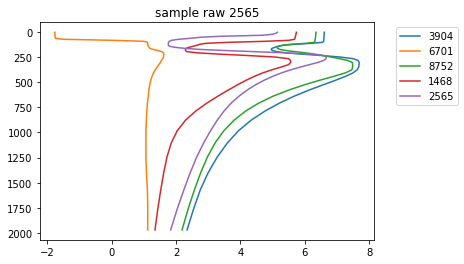

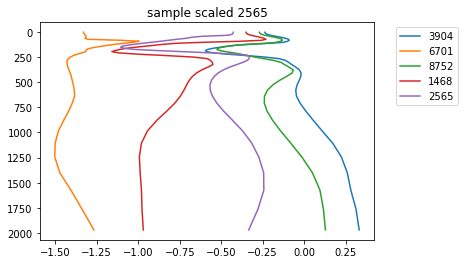

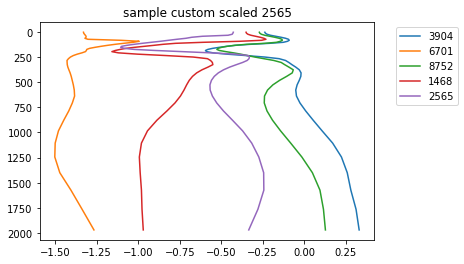

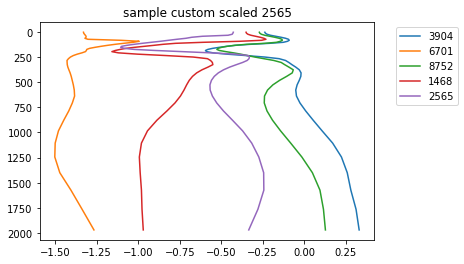

In [28]:
solo = False #Set to true for seperate plots, false for combined plots.
for i in range(5):
    x = np.random.randint(10000)
    tempPointPlot(sampleData[x], x, "sample raw "+str(x), solo*4*i)
    tempPointPlot(sampleDataScaled[x], x, "sample scaled "+str(x), solo*4*i+1)
    tempPointPlot(sampleDataScaled2[x], x, "sample custom scaled "+str(x), solo*4*i+2)
    tempPointPlot(sampleDataScaled2[x], x, "sample custom scaled "+str(x), solo*4*i+3)
    print("Sample "+str(x))
    print("2 - 1: ",sampleDataScaled2[x]-sampleDataScaled[x])
    print("3 - 2: ",sampleDataScaled3[x]-sampleDataScaled2[x])

<br>

### Principle Component Analysis
This process is performed to reduce the number of dimensions of the the data, as well as to improve overall model
performance.

In [10]:
for i in range(1,8):
    pca = PCA(n_components=i) #initialising PCA 
    pca.fit(sampleDataScaled) #fitting model to data
    totalVarianceExplained = np.sum(pca.explained_variance_ratio_)
    print("For "+str(i)+" PCA components, "+str(totalVarianceExplained)+" is explained.") #total variance explained by model.
    if not(pcaNControl) and (totalVarianceExplained > pcaThreshold):
        pcaNControl = i
        print("Threshold of "+str(pcaThreshold)+" exceeded, pcaNControl assigned a value of "+str(i))
print("\nAssigned value of pcaNcontrol = "+str(pcaNControl))

For 1 PCA components, 0.9266304719256508 is explained.
For 2 PCA components, 0.9588689113313313 is explained.
For 3 PCA components, 0.9749409050915275 is explained.
For 4 PCA components, 0.9843397184525013 is explained.
Threshold of 0.98 exceeded, pcaNControl assigned a value of 4
For 5 PCA components, 0.9907582088178929 is explained.
For 6 PCA components, 0.9945447597279461 is explained.
For 7 PCA components, 0.9966979640277571 is explained.

Assigned value of pcaNcontrol = 4


In [11]:
pca = PCA(n_components=pcaNControl) #initialising PCA 
pca.fit(sampleDataScaled) #fitting model to data
sampleDataScaledPCA = pca.transform(sampleDataScaled) #converting input data into PCA representation
print("Data passed through PCA to sampleDataPCA.")

Data passed through PCA to sampleDataPCA.


<br>

### BIC score calculation
To identify the best fitting models a BIC score metric is used, with a lower BIC score indicating a better model. BIC scores for each number of classes will differ based on starting values used in the modelling, so repeated runs of the BIC scoring helps to provide a more overall score for each number of classes.

The number of iterations for each quantity of classes can be controlled by modifying the bicLoopControl variable at the top of the notepad in [Choices for data](#Choices-for-data).

In [ ]:
bicMin = np.infty
bicComponentMin = firstComponentMin
bicRaw1 = np.empty(shape=(0,firstBicLoopControl))

for i in range(firstComponentMin, firstComponentMax + 1, firstIterationSkip):
    bicCurrentArray = np.empty(shape=(0))
    
    for j in range(firstBicLoopControl):    #Number of iterations for each number of components
        GMModel = mixture.GaussianMixture(n_components = i, covariance_type = cvType) #Run modelling
        GMModel.fit(sampleDataScaledPCA)
        
        bicCurrent = GMModel.bic(sampleDataScaledPCA)
        bicCurrentArray = np.append(bicCurrentArray, bicCurrent)
        if bicCurrent < bicMin:   #if latest BIC score is lowest, update and save model
            bicMin = bicCurrent
            bicComponentMin = i
            bestGMModel = GMModel
        
    bicRaw1 = np.append(bicRaw1, [bicCurrentArray], axis=0)
    if i%5 == 0:
        print("Components "+str(i)+" complete.")

if secondBicLoopControl:
    secondComponentMin = bicComponentMin - bicSpread
    secondComponentMax = bicComponentMin + bicSpread
    bicRaw2 = np.empty(shape=(0, secondBicLoopControl))
    
    for i in range(secondComponentMin, secondComponentMax + 1, 1):
        bicCurrentArray = np.empty(shape=(0))

        for j in range(secondBicLoopControl):    #Number of iterations for each number of components
            GMModel = mixture.GaussianMixture(n_components = i, covariance_type = cvType) #Run modelling
            GMModel.fit(sampleDataScaledPCA)
            
            bicCurrent = GMModel.bic(sampleDataScaledPCA)
            bicCurrentArray = np.append(bicCurrentArray, bicCurrent)
            if bicCurrent < bicMin:   #if latest BIC score is lowest, update and save model
                bicMin = bicCurrent
                bicComponentMin = i
                bestGMModel = GMModel

        bicRaw2 = np.append(bicRaw2, [bicCurrentArray], axis=0)
        print("Components "+str(i)+" complete.")
  
    
componentNo = bestGMModel.n_components

if componentNo != bicComponentMin:
    print("Warning, error with assigning optimum GMM")

print("Modelling and scoring complete. The lowest bicScore was "+str(np.round(bicMin, 2))+" for "+str(bicComponentMin)+".")
print("BIC values are stored in bicRaw, with lowest stored in bicMin and model in bestGGModel.")

Components 10 complete.
Components 20 complete.
Components 30 complete.
Components 40 complete.
Components 50 complete.
Components 60 complete.
Components 70 complete.
Components 80 complete.
Components 90 complete.
Components 100 complete.
Components 49 complete.
Components 50 complete.
Components 51 complete.
Components 52 complete.
Components 53 complete.
Components 54 complete.
Components 55 complete.
Components 56 complete.
Components 57 complete.


<br>

### BIC score calculations
The average and minimum BIC scores for each number of components are calculated and stored in the corresponding arrays.

In [ ]:
bicAvg1 = np.empty(shape=(0))
bicAvg2 = np.empty(shape=(0))
bicMin1 = np.empty(shape=(0))
bicMin2 = np.empty(shape=(0))

for i in range(len(bicRaw1)):
    bicAvg1 = np.append(bicAvg1, np.mean(bicRaw1[i]))
    bicMin1 = np.append(bicMin1, np.min(bicRaw1[i]))
    
for i in range(len(bicRaw2)):
    bicAvg2 = np.append(bicAvg2, np.mean(bicRaw2[i]))
    bicMin2 = np.append(bicMin2, np.min(bicRaw2[i]))

print("BIC score sorting finished. Lowest scores for each component value stored in bicMin1/2, with average BIC scores stored in bicAvg1/2.")

<br>

### BIC score plotting
Plotting the BIC scores from the modelling. The minimum BIC score indicates the ideal number of classes to be used in the model.

In [ ]:
bicPlot(bicMin1, firstComponentMin, firstComponentMax, firstIterationSkip, "Initial BIC minimum plot", "Minimum", 1)
bicPlot(bicAvg1, firstComponentMin, firstComponentMax, firstIterationSkip, "Initial BIC average and minimum plot", "Average", 1)
bicPlot(bicMin2, secondComponentMin, secondComponentMax, 1,"Final BIC minimum plot", "Minimum", 2)
bicPlot(bicAvg2, secondComponentMin, secondComponentMax, 1, "Final BIC average and minimum plot", "Average", 2)
plt.axhline(bicMin, color = "Red")

plt.show()
print("Component number with minimum BIC score: "+str(componentNo)+".")

<br>

### Assigning class labels to each profile using the best GMM
Implementation of classification.

In [ ]:
labels = bestGMModel.predict(sampleDataScaledPCA) #assignment of class labels from best GMM

posteriorProbs = bestGMModel.predict_proba(sampleDataScaledPCA) #probability of profile belonging in class
maxPosteriorProbs = np.max(posteriorProbs, axis=1)

try:
    sampleDF = sampleDF.drop(columns=["label", "max posterior prob"]) #removes any previous labels or probabilities
except:
    pass
sampleDF.insert(3, "label", labels, True)
sampleDF.insert(4, "max posterior prob", maxPosteriorProbs, True)
print("Labels identified for model ("+str(componentNo)+" components) and added to sampleDF with associated probability.")

<br>

### Calculating properties of profiles based on class assignment

In [ ]:
sampleDFGrouped = sampleDF.groupby("label") #group profiles according to label
sampleDFMeans = sampleDFGrouped.mean() #calculate mean of all profiles in each class
print("Sample dataframe grouped by label (sampleDFGrouped) and means taken (sampleDFMeans).")

<br>

### Sort the labels based on mean near-surface temperatures

In [ ]:
surfaceMeans = sampleDFMeans[sampleDepthAxis[0]].to_numpy() #Takes first temperature data column
surfaceMeansOrder = np.argsort(surfaceMeans)
di = dict(zip(surfaceMeansOrder, range(0, componentNo)))

try:
    sampleDF = sampleDF.drop(columns = "labelSorted")
except:
    pass
sampleDF.insert(5, "labelSorted", sampleDF["label"].map(di))
print("Sorted labels assigned to sampleDF based on surface temperature, coldest to warmest.")

<br>

### Use pandas to calculate the properties of the profiles by sorted label

In [ ]:
sampleDFSortGrouped = sampleDF.groupby("labelSorted")
sampleDFSortMeans = sampleDFSortGrouped.mean()
sampleDFSortStds = sampleDFSortGrouped.std()
profileCount = sampleDFSortGrouped[sampleDF.columns[0]].count().to_numpy()
print("sampleDF grouped by sorted label (sampleDFSortGrouped), with means and standard deviations calculated for each group (sampleDFSortMeans, sampleDFSortStd).")
print(" Number of samples in each group calculated and stored in profileCount.")

<br>

### Confirmation of sorting
The means printed below should be ordered, going from coldest to warmest.

In [ ]:
print(sampleDFSortMeans[sampleDataDF.columns[0]])

<br>

### Plotting the means and standard deviations of the classes by profile

In [ ]:
tempGroupProfile(sampleDFSortMeans, sampleDFSortStds, 1)
plt.show()

<br>

### Plotting location and cluster

In [ ]:
sampleLabelData = np.array(sampleDF["labelSorted"])
sampleMetaData = np.append(sampleTimeGeo, [sampleLabelData], axis = 0)
print("Sorted label added to sampleMetaData")

In [ ]:
locationPlotGroup(sampleMetaData, (25,25), 1)